# Analyze the data to evaluate the relative performance of different gene weighting methods

Metrics:
1. Number of discoveries
2. Evaluate on contrast between silver standards

In [1]:
%load_ext lab_black

import pandas as pd
import itertools
import numpy as np
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import scdrs
from scipy.stats import ttest_ind

In [2]:
df_trait_info = pd.read_excel("../supp_tables.xlsx", sheet_name=0).set_index(
    "Trait_Identifier"
)
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
data_facs_ct = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name="facs")

# construct control cell-types

brain_neuron_cells = data_facs_ct.obs.cell_ontology_class.str.contains("neuron")
heart_myocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains("myocyte") & (
    data_facs_ct.obs.tissue == "Heart"
)
marrow_monocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains(
    "monocyte"
) & (data_facs_ct.obs.tissue == "Marrow")

t_cells = data_facs_ct.obs.cell_ontology_class.str.contains("T cell")
hepatocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains("hepatocyte")


positive_pairs = {
    "PASS_Schizophrenia_Pardinas2018": data_facs_ct.obs.index[brain_neuron_cells],
    "PASS_MDD_Howard2019": data_facs_ct.obs.index[brain_neuron_cells],
    "PASS_AtrialFibrillation_Nielsen2018": data_facs_ct.obs.index[heart_myocyte_cells],
    "PASS_Rheumatoid_Arthritis": data_facs_ct.obs.index[t_cells],
    "UKB_460K.biochemistry_LDLdirect": data_facs_ct.obs.index[hepatocyte_cells],
}

negative_pairs = {
    "PASS_Schizophrenia_Pardinas2018": data_facs_ct.obs.index[t_cells],
    "PASS_MDD_Howard2019": data_facs_ct.obs.index[t_cells],
    "PASS_AtrialFibrillation_Nielsen2018": data_facs_ct.obs.index[brain_neuron_cells],
    "PASS_Rheumatoid_Arthritis": data_facs_ct.obs.index[hepatocyte_cells],
    "UKB_460K.biochemistry_LDLdirect": data_facs_ct.obs.index[brain_neuron_cells],
}
trait_list = list(positive_pairs.keys())
dict_control_pairs = {
    trait: [positive_pairs[trait], negative_pairs[trait]] for trait in trait_list
}

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [3]:
# gwas_weight_list = [f"top{n}" for n in [100, 500, 1000, 2000]] + [
#     f"fwer{n}" for n in [1000, 2000]
# ]
# gwas_weight_list = [
#     f"{m}-{w}" for m, w in itertools.product(gwas_weight_list, ["zscore", "uniform"])
# ]

# method_list = [
#     f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
# ]

gwas_weight_list = (
    [f"top-{n}" for n in [100, 500, 1000, 2000]]
    + [f"fwer5-{n}" for n in [1000, 2000]]
    + [f"fdr1-{n}" for n in [1000, 2000]]
    + [f"fdr5-{n}" for n in [1000, 2000]]
)
gwas_weight_list = [
    f"{m}-{w}" for m, w in itertools.product(gwas_weight_list, ["zscore", "uniform"])
]
method_list = [
    f"{m}.{w}" for m, w in itertools.product(gwas_weight_list, ["uniform", "vs"])
]

In [4]:
def summarize(method):
    df_plot = {
        "method": [],
        "trait": [],
        "n_discovery": [],
        "tstats": [],
        "meanshift": [],
    }

    for trait in tqdm(dict_control_pairs):
        df_score = pd.read_csv(
            f"tms_facs/score_file/{method}/{trait}.score.gz", sep="\t", index_col=0
        )
        df_score["fdr"] = multipletests(df_score["pval"], method="fdr_bh")[1]

        positive_cells = df_score.index.isin(dict_control_pairs[trait][0])
        negative_cells = df_score.index.isin(dict_control_pairs[trait][1])

        df_plot["tstats"].append(
            ttest_ind(
                df_score["zscore"][positive_cells],
                df_score["zscore"][negative_cells],
                equal_var=False,
            )[0]
        )

        df_plot["method"].append(method)
        df_plot["trait"].append(trait)
        df_plot["n_discovery"].append(np.sum(df_score["fdr"] < 0.1))

        df_plot["meanshift"].append(
            df_score["zscore"][positive_cells].mean()
            - df_score["zscore"][negative_cells].mean()
        )
    return pd.DataFrame(df_plot)

In [5]:
df_plot = pd.concat([summarize(method) for method in method_list])

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


In [6]:
df_plot["gwas_weight"] = df_plot["method"].apply(lambda x: x.split(".")[0])
df_plot["sc_weight"] = df_plot["method"].apply(lambda x: x.split(".")[1])

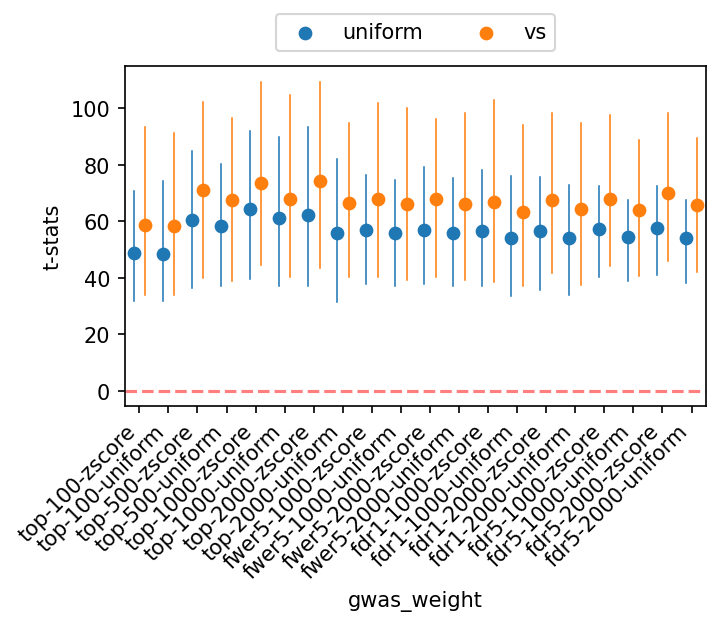

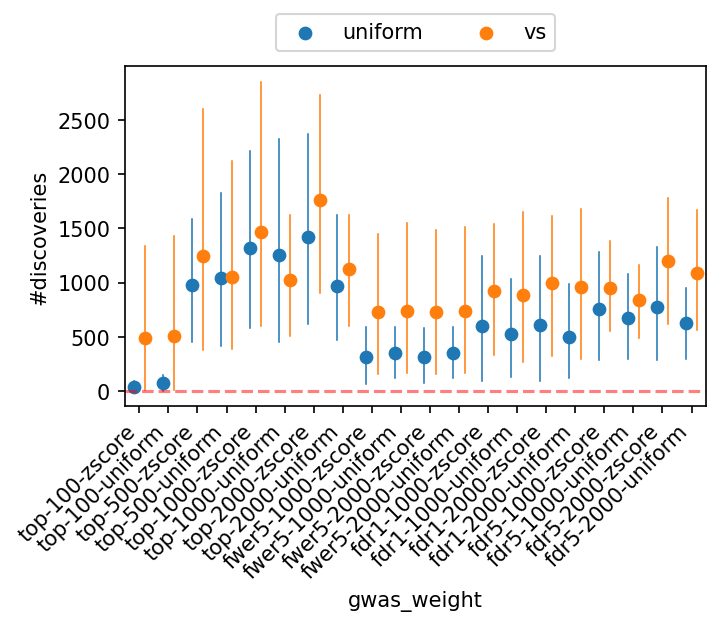

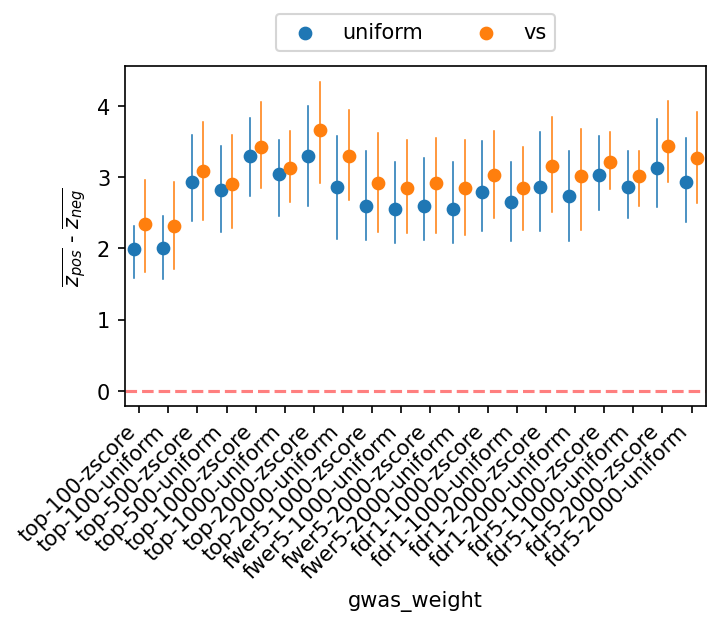

In [7]:
for y in ["tstats", "n_discovery", "meanshift"]:
    fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
    sns.pointplot(
        data=df_plot,
        x="gwas_weight",
        y=y,
        hue="sc_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(loc="center", bbox_to_anchor=[0.5, 1.1], ncol=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

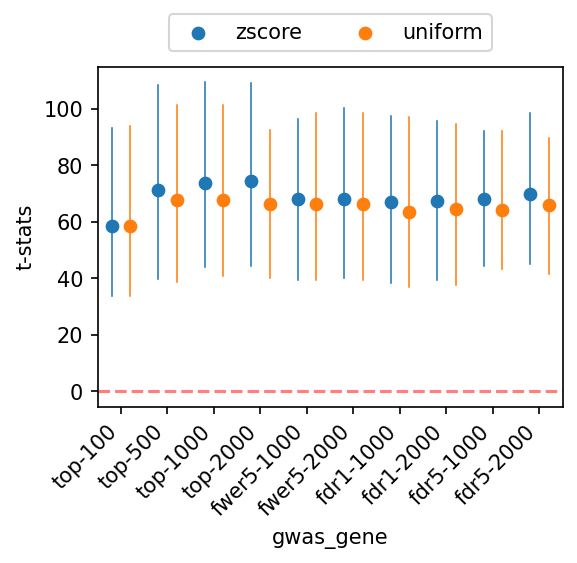

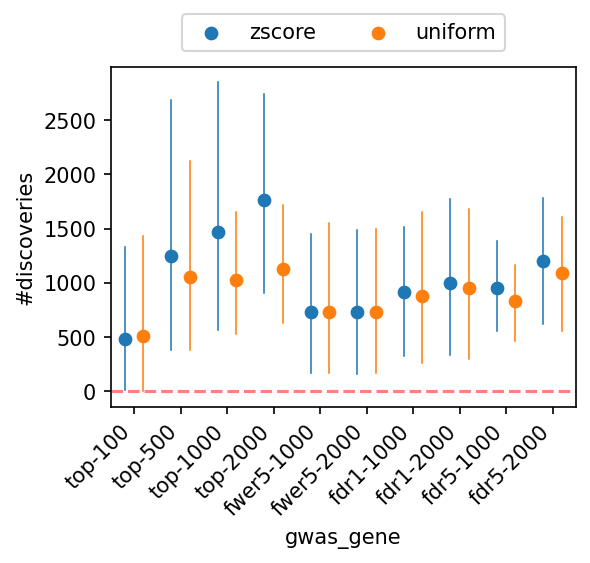

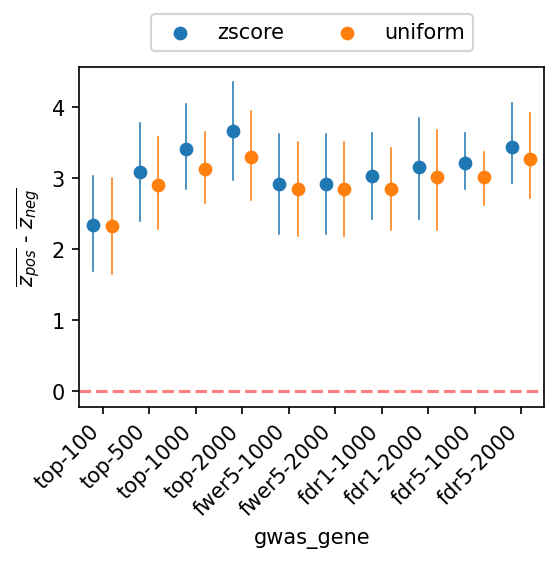

In [8]:
for y in ["tstats", "n_discovery", "meanshift"]:
    df_tmp = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])
    df_tmp["gwas_gene"] = df_tmp["gwas_weight"].apply(lambda x: x.rsplit("-", 1)[0])
    df_tmp["gwas_gene_weight"] = df_tmp["gwas_weight"].apply(
        lambda x: x.rsplit("-", 1)[1]
    )

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
    sns.pointplot(
        data=df_tmp,
        x="gwas_gene",
        y=y,
        hue="gwas_gene_weight",
        errwidth=0.75,
        join=False,
        scale=0.75,
        dodge=0.4,
        ax=ax,
    )
    ax.legend(loc="center", bbox_to_anchor=[0.5, 1.1], ncol=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    if y == "tstats":
        ax.set_ylabel("t-stats")
    elif y == "n_discovery":
        ax.set_ylabel("#discoveries")
    elif y == "meanshift":
        ax.set_ylabel("$\\overline{z_{pos}}$ - $\\overline{z_{neg}}$")
    else:
        raise NotImplementedError
    ax.axhline(y=0, ls="--", color="red", alpha=0.5)

Therefore, we consistently use "vs" weighting for now

# Numerical results

In [9]:
df_plot = df_plot[df_plot.sc_weight == "vs"].drop(columns=["sc_weight"])

# trait-specific maximum

dict_max_n_discovery = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["n_discovery"])).to_dict()
)
df_plot["normalized_n_discovery"] = df_plot.apply(
    lambda x: x["n_discovery"] / dict_max_n_discovery[x.trait], axis=1
)

dict_max_tstats = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["tstats"])).to_dict()
)
df_plot["normalized_tstats"] = df_plot.apply(
    lambda x: x["tstats"] / dict_max_tstats[x.trait], axis=1
)


dict_max_meanshift = (
    df_plot.groupby("trait").apply(lambda x: np.max(x["meanshift"])).to_dict()
)
df_plot["normalized_meanshift"] = df_plot.apply(
    lambda x: x["meanshift"] / dict_max_meanshift[x.trait], axis=1
)

In [10]:
df_plot_avg = df_plot.groupby("gwas_weight").mean().loc[gwas_weight_list]

In [11]:
display(df_plot_avg)

,n_discovery,tstats,meanshift,normalized_n_discovery,normalized_tstats,normalized_meanshift
gwas_weight,,,,,,
top-100-zscore,483.0,58.556436,2.340767,0.228983,0.738409,0.630160
top-100-uniform,510.0,58.274652,2.319069,0.232083,0.735150,0.623985
top-500-zscore,1249.4,71.020688,3.090258,0.613141,0.867304,0.813427
top-500-uniform,1051.4,67.510070,2.909764,0.537309,0.828705,0.764807
top-1000-zscore,1471.4,73.498631,3.417208,0.726138,0.903950,0.907078
top-1000-uniform,1021.6,67.784323,3.130532,0.567582,0.841601,0.833363
top-2000-zscore,1760.8,74.207797,3.662786,0.973900,0.909603,0.967658
top-2000-uniform,1125.6,66.323575,3.303140,0.756777,0.822410,0.872996
fwer5-1000-zscore,730.2,67.938316,2.913365,0.431342,0.853779,0.771125


In [12]:
from scipy.stats import pearsonr, spearmanr

df_plot = {"method": [], "trait": [], "n_discovery": []}

for trait in trait_list:
    # for trait in df_trait_info.index:
    dict_df_score = {}
    for w in ["top-1000-uniform", "top-1000-zscore"]:
        df_score = pd.read_csv(
            f"tms_facs/score_file/{w}.vs/{trait}.score.gz",
            sep="\t",
            index_col=0,
        )
        df_score["fdr"] = multipletests(df_score["pval"], method="fdr_bh")[1]
        dict_df_score[w] = df_score
    print(
        trait,
        pearsonr(
            dict_df_score["top-1000-uniform"].zscore,
            dict_df_score["top-1000-zscore"].zscore,
        )[0],
    )

PASS_Schizophrenia_Pardinas2018 0.9859760479978108
PASS_MDD_Howard2019 0.986197294363645
PASS_AtrialFibrillation_Nielsen2018 0.9619784204619377
PASS_Rheumatoid_Arthritis 0.975524836764889
UKB_460K.biochemistry_LDLdirect 0.976120990430571
